In [1]:
import os
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
from io import StringIO
import re
from IPython.display import display, Latex

## reading results

In [157]:
def get_results(res_path, section_name):
    # group file names by configuration
    results_by_specs = defaultdict(list)
    for fname in os.listdir(res_path):
        if not fname.endswith('.txt'):
            continue

        try:
            spec, day, hour = fname[:-len('.txt')].split('-')
            
            if 'MOSTEstimator' in fname:
                _, model, most = spec.split('_')
                features = 'zL'
            else:
                _, model, features, trend, most = spec.split('_')
        except:
            print('bad name:', fname)
            continue

        results_by_specs[(model, features, trend, most)].append(fname)
    
    # for each config, find and parse most recent result file
    df_rows, df_cols = [], None
    for spec, files in results_by_specs.items():
        res_file, res_lines, found = list(sorted(files))[-1], [], False
        with open(os.path.join(res_path, res_file)) as f:
            for i, row in enumerate(f):
                rr = row.strip()
                
                if found and not rr.startswith('**'):
                    res_lines.append(rr)
                elif found and rr.startswith('**'):
                    break
                elif not found and rr.startswith('**' + section_name):
                    found = True
        
        if not found:
            raise RuntimeError('section %s not found in file %s' % (section_name, res_file))
        elif not res_lines:
            raise RuntimeError('section %s is empty in file %s' % (section_name, res_file))

        csv_text = re.sub('[ \t]+', ',', '\n'.join(res_lines))
        section_df = pd.read_csv(StringIO(csv_text))
        for col in section_df:
            for i, val in enumerate(section_df[col]):
                df_rows.append(list(spec) + [i, col, val])

        if df_cols is None:
            df_cols = [
                'estimator', 'features', 'trend', 'most', 'trial', 'column', 'value'
            ]

    results = pd.DataFrame(df_rows, columns=df_cols)
    return results


res = get_results('dev/results', 'raw scores')
res.head(5)

,estimator,features,trend,most,trial,column,value
0,KNeighborsRegressor,f2,trend,nomost,0,explained_variance_score,0.784025
1,KNeighborsRegressor,f2,trend,nomost,1,explained_variance_score,0.774970
2,KNeighborsRegressor,f2,trend,nomost,2,explained_variance_score,0.793851
3,KNeighborsRegressor,f2,trend,nomost,3,explained_variance_score,0.780148
4,KNeighborsRegressor,f2,trend,nomost,4,explained_variance_score,0.796260


In [158]:
paras = get_results('dev/results', 'raw parameters')
paras.head(5)

,estimator,features,trend,most,trial,column,value
0,KNeighborsRegressor,f2,trend,nomost,0,n_neighbors,24
1,KNeighborsRegressor,f2,trend,nomost,1,n_neighbors,16
2,KNeighborsRegressor,f2,trend,nomost,2,n_neighbors,21
3,KNeighborsRegressor,f2,trend,nomost,3,n_neighbors,40
4,KNeighborsRegressor,f2,trend,nomost,4,n_neighbors,16


## generation of charts

In [177]:
def paint_boxplot(bplot, all_color=None, **kwargs):
    # use all_color to paing all elements of the same color
    # or specify color for each element in kwargs
    # kwargs take precedence over all_color
    #
    # NB available elements are
    # boxes, medians, whiskers, caps, fliers, means

    for key in bplot:
        color = kwargs.get(key, all_color)
        if color:
            for element in bplot[key]:
                element.set_color(color)


def make_base_plot(res, estimator, most, column, save_path=None, plot_all=False):
    most = 'most' if most else 'nomost'
    plot_data, found = [], False
    fig, ax = plt.subplots()

    for features in range(1, 6):
        for tidx, trend in enumerate(['trend', 'notrend']):
            vals = res[
                (res.estimator == estimator) &
                (res.most == most) &
                (res.features == 'f%d' % features) &
                (res.trend == trend) & 
                (res.column == column)
            ]['value'].values
            
            if vals.size == 0:
                plot_data.append([])
                continue

            if plot_all:
                plt.scatter([3 * (features - 1) + tidx] * len(vals), vals,
                            color='C%d' % tidx, s=7, zorder=10, marker='o')

            plot_data.append(vals)
            found = True

    if not found:
        print('no results for estimator %s on %s %s' % (
            column, estimator, most
        ))
        return None, None
    
    boxplot_kwargs = {
        'showmeans': True,
        'patch_artist': False,
        'zorder': 5,
        'showfliers': not plot_all,
    }
    
    # trend
    bp1 = ax.boxplot(plot_data[::2], positions=range(0, 15, 3),
                     sym='C0.', **boxplot_kwargs)
    paint_boxplot(bp1, 'C0')

    # no trend
    bp2 = ax.boxplot(plot_data[1::2], positions=range(1, 15, 3),
                     sym='C1.', **boxplot_kwargs)
    paint_boxplot(bp2, 'C1')
    
    # most baseline
    most_data = res[
        (res.estimator == 'MOSTEstimator') &
        (res.most == most) &
        (res.column == column)
    ]
    if most_data.empty:
        print('no MOST baseline found for', column)
    else:
        bpm = ax.boxplot(most_data.value, positions=[-2],
                         sym='k.', meanprops={'color': 'k'},
                         widths=[0.5],
                         **boxplot_kwargs)
        paint_boxplot(bpm, 'k')
        
    #most_mean, most_std = 0.332056, 0.017246
    #bot, top = most_mean - 2 * most_std, most_mean + 2 * most_std
    #plt.plot([-1, 14], [most_mean, most_mean], c='C4')
    #ax.fill_between([-1, 14], [bot, bot], [top, top], alpha=0.25, color='C4')
    
    ax.margins(y=0.05)
    ax.set_xlim(-3, 14)
    ax.set_xticks([-2, 0.5, 3.5, 6.5, 9.5, 12.5])
    ax.set_xticklabels(['B', 'F1', 'F2', 'F3', 'F4', 'F5'])
    
    fig.tight_layout()
    
    if save_path is not None:
        fig.savefig(os.path.join(
            save_path, 'result_%s_%s_%s.png' % (estimator, most, column)
        ))
    
    ax.set_title(
        estimator +
        ' - ' + '%smost' % ('' if most else 'no ') +
        ' - ' + column.replace('_', ' ')
    )

    return fig, ax

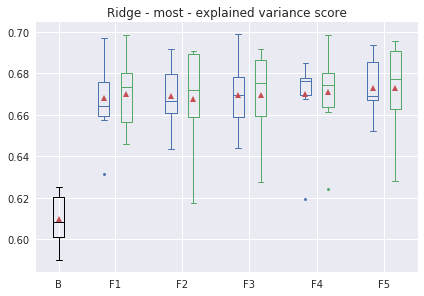

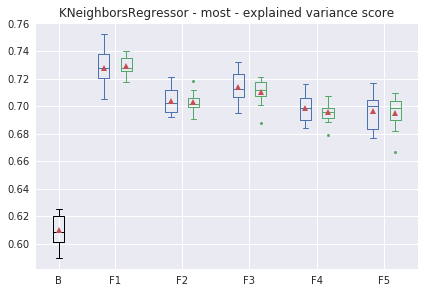

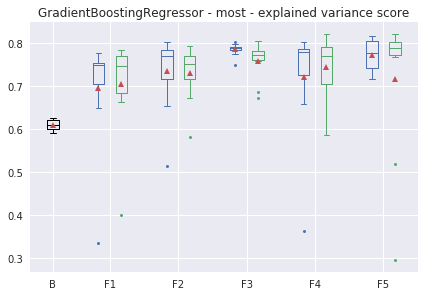

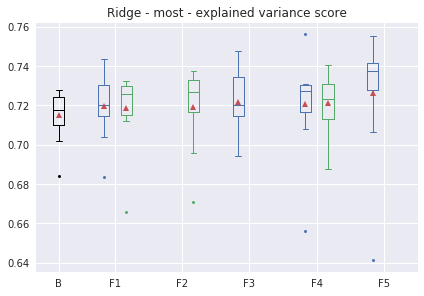

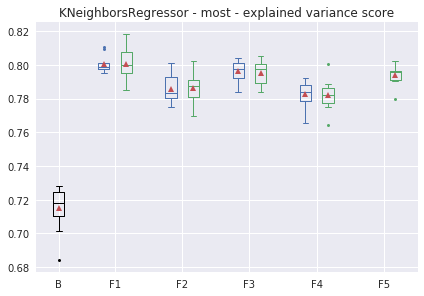

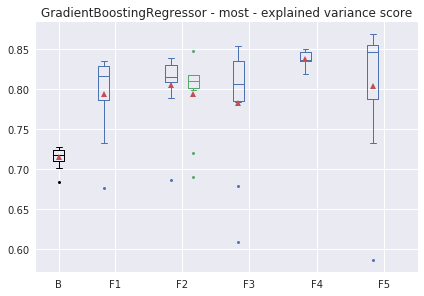

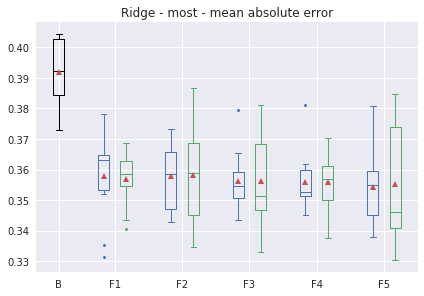

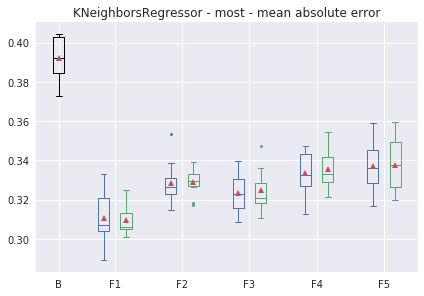

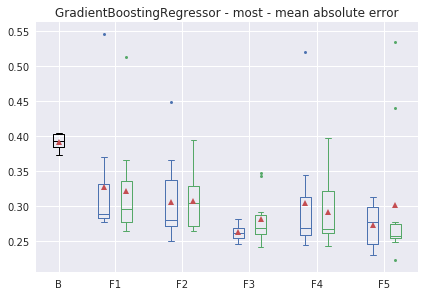

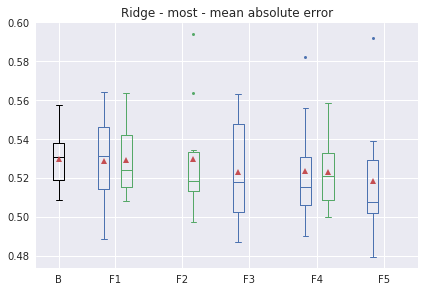

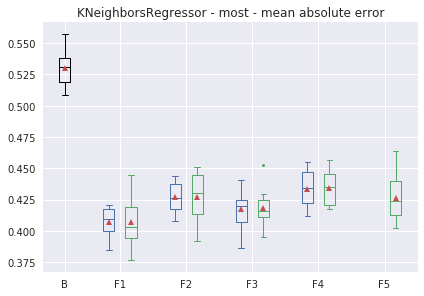

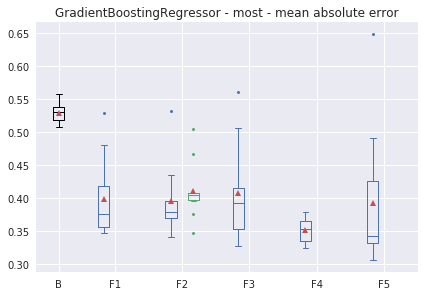

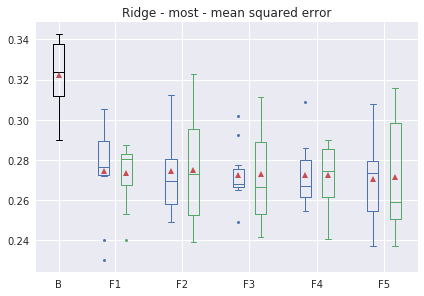

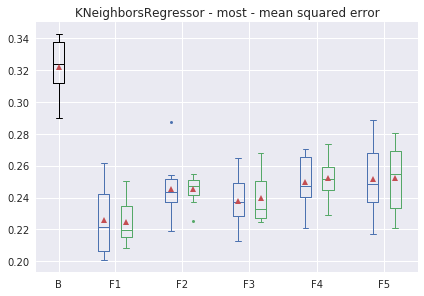

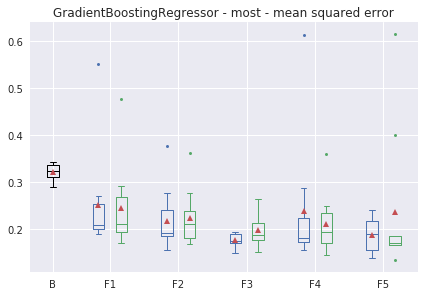

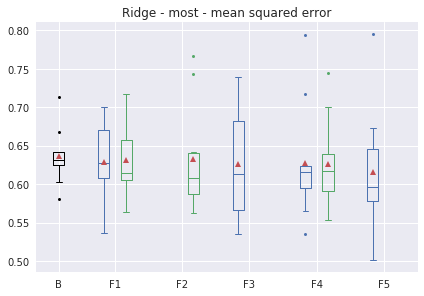

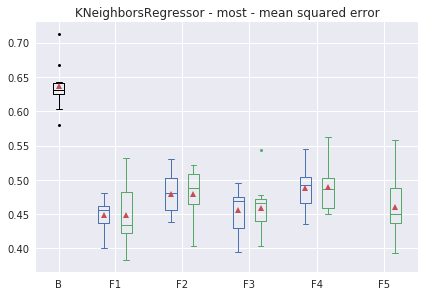

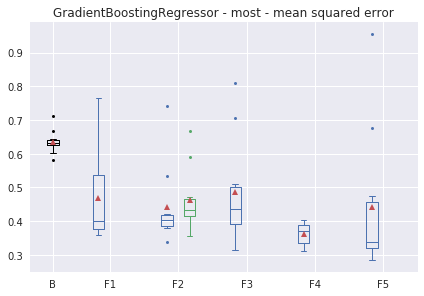

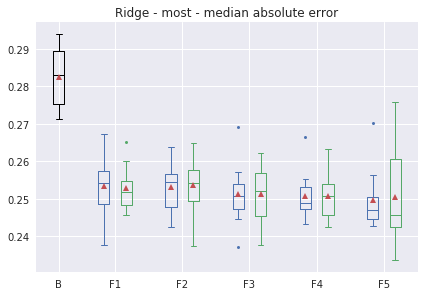

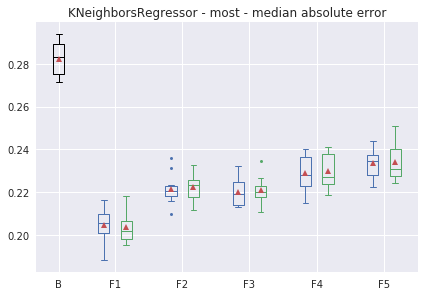

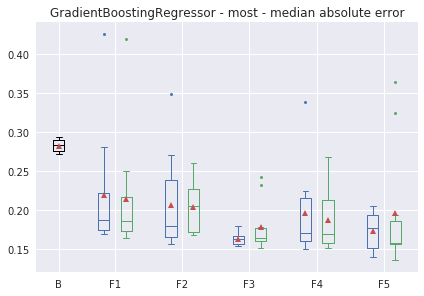

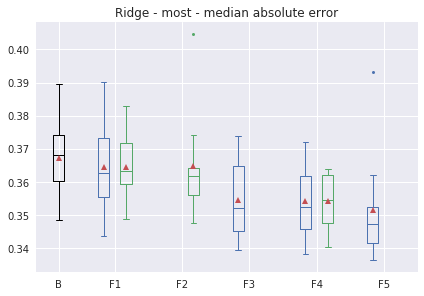

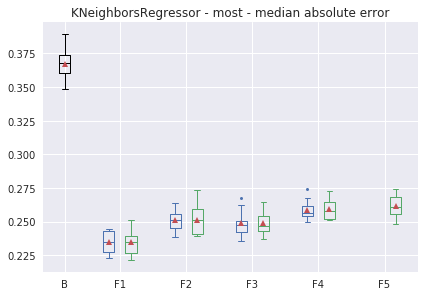

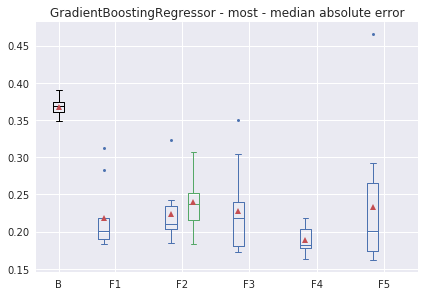

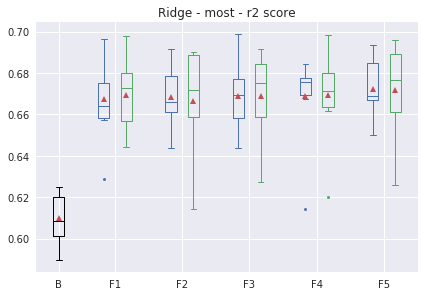

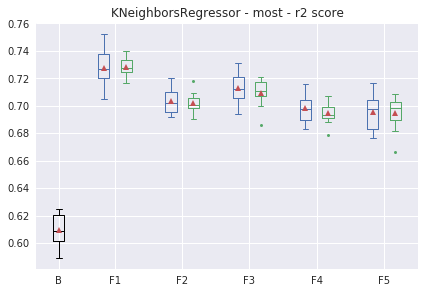

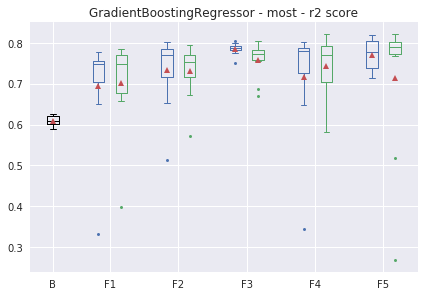

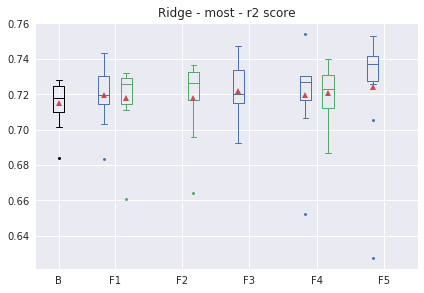

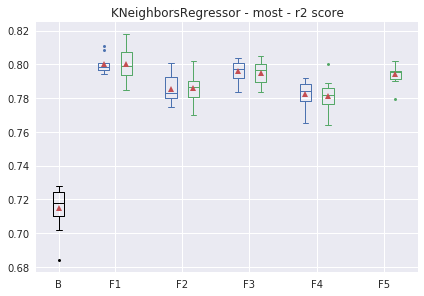

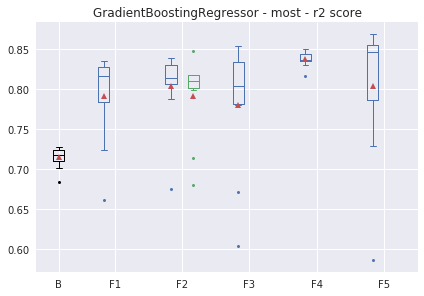

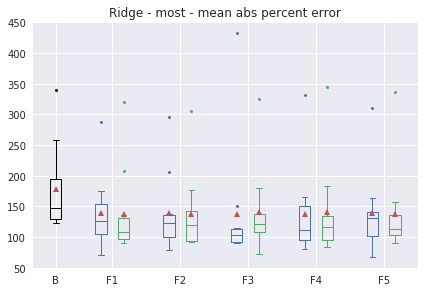

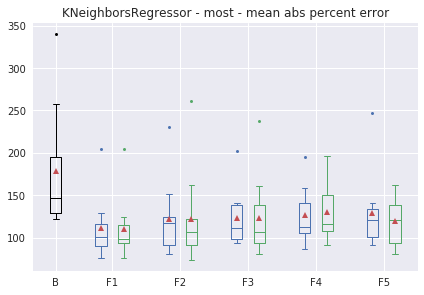

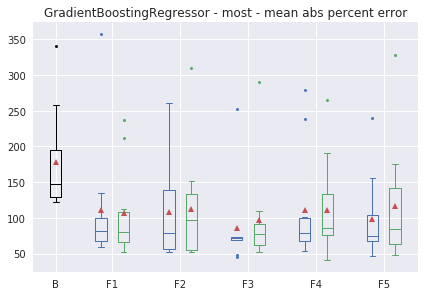

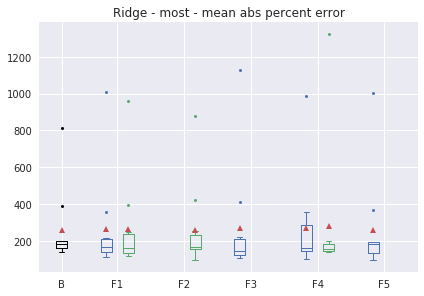

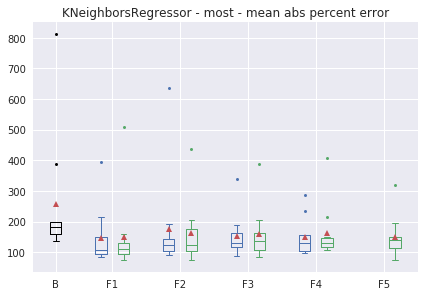

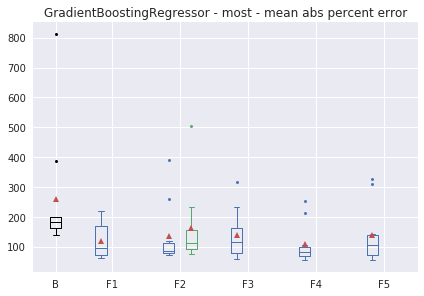

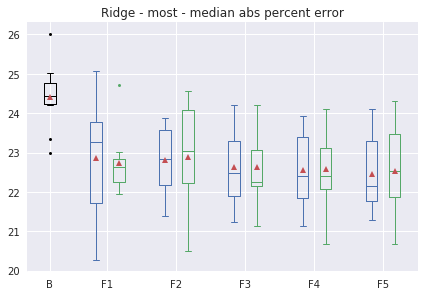

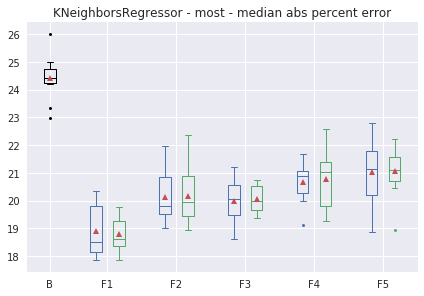

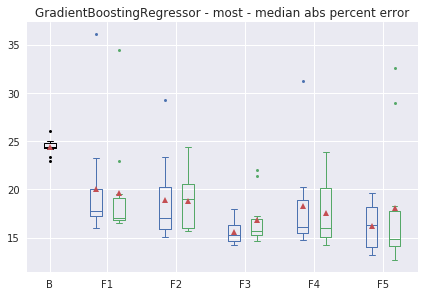

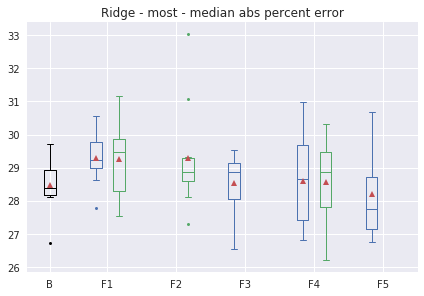

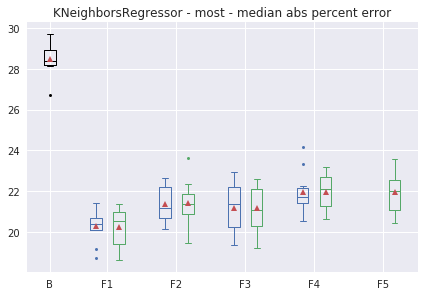

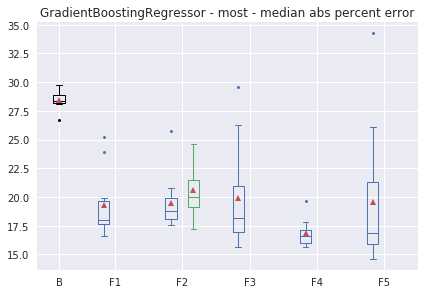

no results for estimator train_mse on Ridge most


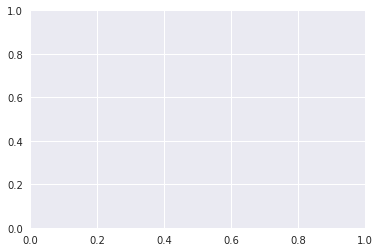

no results for estimator train_mse on KNeighborsRegressor most


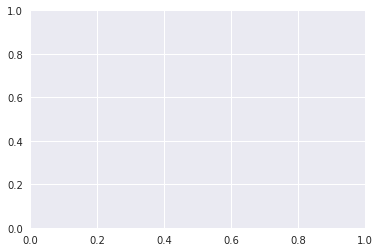

no results for estimator train_mse on GradientBoostingRegressor most


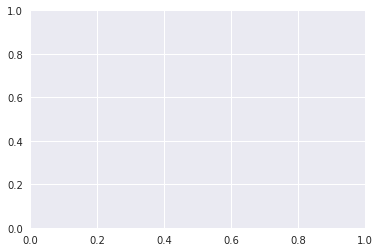

no results for estimator train_mse on Ridge nomost


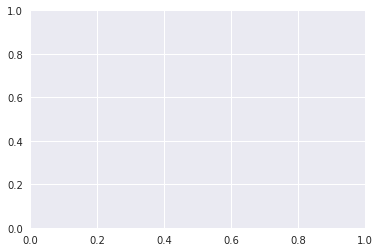

no results for estimator train_mse on KNeighborsRegressor nomost


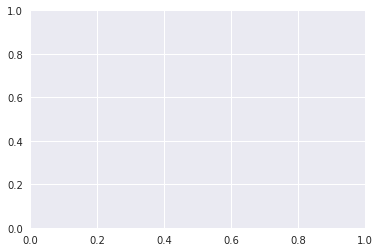

no results for estimator train_mse on GradientBoostingRegressor nomost


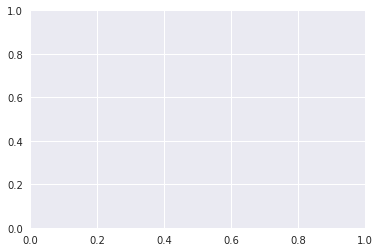

In [178]:
for met in res.column.unique():
    for most in [True, False]:
        plt.show(make_base_plot(res, 'Ridge', most, met, 'manuscript/images')[0])
        plt.show(make_base_plot(res, 'KNeighborsRegressor', most, met, 'manuscript/images')[0])
        plt.show(make_base_plot(res, 'GradientBoostingRegressor', most, met, 'manuscript/images')[0])

check if outliers all happened in the same outer folds

In [83]:
res[
    (res.column == 'mean_squared_error')
].groupby(['estimator', 'features', 'trend']).apply(
    lambda g: g.loc[g.value.idxmax()]
)[['trial', 'value']]

trial     value
estimator                 features trend                   
GradientBoostingRegressor f1       notrend      8  0.477514
                                   trend        2  0.766394
                          f2       notrend      0  0.667462
                                   trend        8  0.742154
                          f3       notrend      7  0.263872
                                   trend        6  0.809069
                          f4       notrend      8  0.360943
                                   trend        3  0.613572
                          f5       notrend      8  0.616439
                                   trend        8  0.240907
KNeighborsRegressor       f1       notrend      9  0.532414
                                   trend        1  0.261768
                          f2       notrend      2  0.521940
                                   trend        6  0.529899
                          f3       notrend      7  0.544023
                                   trend        5  0.264899
                          f4       notrend      7  0.273434
                                   trend        1  0.544751
                          f5       notrend      9  0.280654
                                   trend        7  0.288884
Ridge                     f1       notrend      6  0.717428
                                   trend        8  0.716698
                          f2       notrend      4  0.322923
                                   trend        6  0.312456
                          f3       notrend      8  0.311161
                                   trend        7  0.739762
                          f4       notrend      6  0.745151
                                   trend        9  0.794517
                          f5       notrend      8  0.315830
                                   trend        6  0.795682

## generation of result tables

In [8]:
# for now we dont have nomost results, so we just copy the most ones
# so that we can preview how the tables will look like once they are complete
all_most = {'most', 'nomost'}
missing = all_most - set(res.most)
if missing:
    print('*** WARNING')
    print('replacing missing values in %s with fake measures' % missing)
    allres, missing = [], list(missing)[0]
    for row in res.values:
        allres.append(row)
        newrow = [x for x in row]
        newrow[3] = missing
        allres.append(newrow)
    allres = pd.DataFrame(allres, columns=res.columns)
else:
    allres = res

In [64]:
# rename stuff
renamed = allres[
    (allres.column != 'explained_variance_score')
].replace({
    'most': {'most': 'Y', 'nomost': 'N'},
    'trend': {'trend': 'Y', 'notrend': 'N'},
    'column': {
        'mean_squared_error': 'MSE',
        'median_squared_error': 'mSE',
        'mean_absolute_error': 'MAE',
        'median_absolute_error': 'mAE',
        'mean_abs_percent_error': 'MAPE',
        'median_abs_percent_error': 'mAPE',
        'r2_score': '$R^2$',
    },
    'features': {'f1': 'F1', 'f2': 'F2', 'f3': 'F3', 'f4': 'F4', 'f5': 'F5'}
}).rename(columns={
    'features': 'Features',
    'column': 'Metric',
    'trend': 'Trend',
    'most': 'MOST'
})

most = 'both'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

# one table for each estimator
for estimator in renamed.estimator.unique():
    if most == 'both':
        index = ['Metric', 'MOST', 'Trend']
        most_filter = True
    elif most == 'yes':
        index = ['Metric', 'Trend']
        most_filter = renamed.MOST == 'Y'
    elif most == 'no':
        index = ['Metric', 'Trend']
        most_filter = renamed.MOST == 'N'
    else:
        raise ValueError('most should be either yes, no, or both')
    
    est_res = renamed[
        (renamed.estimator == estimator) & most_filter
    ].pivot_table(
        columns='Features',
        values='value',
        index=index,
        aggfunc=lambda vals: '%.4f\n(%.4f)' % (vals.mean(), vals.std())
    )
    
    # useless and pollute output
    est_res.index.name = ''
    est_res.columns.name = ''
    
    # change order of columns
    est_res = est_res.reindex([
        'MSE', '$R^2$', 'MAE', 'mAE', 'MAPE', 'mAPE'
    ], level=0)
    display(est_res)

    # use makecell to insert a line break between mean and std
    def format_col(text):
        return '\makecell[c]{%s}' % text.replace('\n', r'\\')

    latex = est_res.to_latex(
        escape=False,
        bold_rows=True,
        column_format='asd',
        multirow=True,
        formatters={
            'F1': format_col,
            'F2': format_col,
            'F3': format_col,
            'F4': format_col,
            'F5': format_col,
        }
    )

    # replace double clines with a single hline
    latex = re.sub(r'\\cline{.*?}\n\\cline{.*?}', '\hline', latex)
    
    # add tiny vertical space between cells
    # somewhat helps readability
    latex = '\centering\setcellgapes{0.15ex}\makegapedcells' + latex
    
    # since we used makecell to insert newlines inside each cell, we have
    # to double the vertical size of the multirows
    # also move column name slightly upwards to make it aligned with center line
    # (move up by 1ex and down by 0.15ex to balance the padding)
    latex = re.sub(r'\\multirow{(\d+)}{\*}{(.*?)}', 
                   lambda m: r'\multirowcell{%d}[0.75ex][c]{%s}' % (2 * int(m[1]), m[2]),
                   latex)

    # use tabular* environment to make table fill the page width
    latex = latex.replace(
        r'\begin{tabular}{asd}',
        r'\begin{tabular*}{\textwidth}{c @{\extracolsep{\fill}} %sc|ccccc}' % (
            'c' if most == 'both' else ''
        )
    ).replace(r'\end{tabular}', r'\end{tabular*}')
    
    with open('manuscript/include/results_%s.tex' % estimator, 'w') as f:
        f.write(latex)

F1                    F2  \
Metric MOST Trend                                               
MSE    N    N      0.4480\n(0.0453)      0.4799\n(0.0405)       
            Y      0.4482\n(0.0245)      0.4800\n(0.0298)       
       Y    N      0.2248\n(0.0139)      0.2451\n(0.0090)       
            Y      0.2259\n(0.0230)      0.2454\n(0.0183)       
$R^2$  N    N      0.8003\n(0.0106)      0.7858\n(0.0089)       
            Y      0.8001\n(0.0054)      0.7856\n(0.0089)       
       Y    N      0.7284\n(0.0073)      0.7019\n(0.0083)       
            Y      0.7274\n(0.0143)      0.7033\n(0.0097)       
MAE    N    N      0.4073\n(0.0209)      0.4272\n(0.0208)       
            Y      0.4071\n(0.0125)      0.4271\n(0.0121)       
       Y    N      0.3095\n(0.0090)      0.3289\n(0.0073)       
            Y      0.3104\n(0.0131)      0.3286\n(0.0110)       
mAE    N    N      0.2348\n(0.0100)      0.2515\n(0.0116)       
            Y      0.2347\n(0.0086)      0.2511\n(0.0077)       
       Y    N      0.2036\n(0.0077)      0.2224\n(0.0066)       
            Y      0.2045\n(0.0079)      0.2216\n(0.0074)       
MAPE   N    N      149.6721\n(128.3881)  162.0056\n(104.5180)   
            Y      147.6797\n(95.0247)   176.1501\n(164.4073)   
       Y    N      110.3192\n(35.8902)   121.5696\n(54.9411)    
            Y      110.7074\n(36.5682)   122.2460\n(44.1736)    
mAPE   N    N      20.2472\n(0.9662)     21.4395\n(1.0948)      
            Y      20.2752\n(0.8160)     21.3802\n(0.8933)      
       Y    N      18.7901\n(0.6521)     20.1785\n(1.0779)      
            Y      18.8906\n(0.9461)     20.1434\n(0.9649)      

                                    F3                   F4  \
Metric MOST Trend                                             
MSE    N    N      0.4595\n(0.0395)     0.4894\n(0.0356)      
            Y      0.4558\n(0.0333)     0.4881\n(0.0367)      
       Y    N      0.2397\n(0.0153)     0.2520\n(0.0128)      
            Y      0.2377\n(0.0171)     0.2496\n(0.0174)      
$R^2$  N    N      0.7950\n(0.0072)     0.7815\n(0.0095)      
            Y      0.7960\n(0.0063)     0.7826\n(0.0080)      
       Y    N      0.7096\n(0.0105)     0.6948\n(0.0085)      
            Y      0.7128\n(0.0113)     0.6983\n(0.0108)      
MAE    N    N      0.4184\n(0.0161)     0.4345\n(0.0146)      
            Y      0.4175\n(0.0163)     0.4338\n(0.0151)      
       Y    N      0.3247\n(0.0108)     0.3354\n(0.0103)      
            Y      0.3234\n(0.0112)     0.3337\n(0.0115)      
mAE    N    N      0.2489\n(0.0088)     0.2593\n(0.0081)      
            Y      0.2489\n(0.0097)     0.2588\n(0.0073)      
       Y    N      0.2209\n(0.0064)     0.2300\n(0.0084)      
            Y      0.2199\n(0.0068)     0.2289\n(0.0086)      
MAPE   N    N      158.8155\n(88.7095)  163.8465\n(91.1136)   
            Y      153.0072\n(71.9852)  149.9039\n(63.2003)   
       Y    N      122.5099\n(47.6116)  130.4516\n(33.2102)   
            Y      122.7503\n(33.5558)  126.0556\n(32.6292)   
mAPE   N    N      21.1605\n(1.1530)    21.9723\n(0.8759)     
            Y      21.2038\n(1.2407)    21.9414\n(1.0811)     
       Y    N      20.0578\n(0.5043)    20.7687\n(1.0568)     
            Y      19.9896\n(0.7828)    20.6616\n(0.7322)     

                                    F5  
Metric MOST Trend                       
MSE    N    N      0.4598\n(0.0477)     
            Y      None                 
       Y    N      0.2522\n(0.0226)     
            Y      0.2518\n(0.0212)     
$R^2$  N    N      0.7941\n(0.0066)     
            Y      None                 
       Y    N      0.6947\n(0.0128)     
            Y      0.6952\n(0.0133)     
MAE    N    N      0.4265\n(0.0195)     
            Y      None                 
       Y    N      0.3378\n(0.0145)     
            Y      0.3373\n(0.0127)     
mAE    N    N      0.2616\n(0.0088)     
            Y      None                 
       Y    N      0.2341\n(0.0092)     
          

F1                    F2  \
Metric MOST Trend                                              
MSE    N    N      None                 0.4628\n(0.0946)       
            Y      0.4689\n(0.1408)     0.4408\n(0.1169)       
       Y    N      0.2451\n(0.0910)     0.2239\n(0.0597)       
            Y      0.2513\n(0.1097)     0.2183\n(0.0680)       
$R^2$  N    N      None                 0.7919\n(0.0523)       
            Y      0.7913\n(0.0567)     0.8039\n(0.0482)       
       Y    N      0.7025\n(0.1154)     0.7303\n(0.0661)       
            Y      0.6953\n(0.1324)     0.7339\n(0.0907)       
MAE    N    N      None                 0.4116\n(0.0442)       
            Y      0.3994\n(0.0618)     0.3959\n(0.0536)       
       Y    N      0.3207\n(0.0751)     0.3073\n(0.0419)       
            Y      0.3264\n(0.0829)     0.3062\n(0.0630)       
mAE    N    N      None                 0.2393\n(0.0362)       
            Y      0.2185\n(0.0438)     0.2236\n(0.0393)       
       Y    N      0.2142\n(0.0767)     0.2036\n(0.0321)       
            Y      0.2197\n(0.0803)     0.2068\n(0.0640)       
MAPE   N    N      None                 161.4667\n(128.9329)   
            Y      118.5098\n(60.7191)  134.4602\n(106.1033)   
       Y    N      106.7338\n(64.6517)  112.7565\n(78.4367)    
            Y      111.1031\n(89.4484)  108.6330\n(71.4988)    
mAPE   N    N      None                 20.6016\n(2.2858)      
            Y      19.3325\n(2.9030)    19.4937\n(2.4320)      
       Y    N      19.5859\n(5.5771)    18.8398\n(2.9050)      
            Y      20.0375\n(6.0566)    18.8467\n(4.4927)      

                                    F3                   F4  \
Metric MOST Trend                                             
MSE    N    N      None                 None                  
            Y      0.4856\n(0.1552)     0.3633\n(0.0337)      
       Y    N      0.1995\n(0.0385)     0.2127\n(0.0623)      
            Y      0.1774\n(0.0145)     0.2387\n(0.1373)      
$R^2$  N    N      None                 None                  
            Y      0.7807\n(0.0812)     0.8374\n(0.0095)      
       Y    N      0.7587\n(0.0452)     0.7421\n(0.0727)      
            Y      0.7851\n(0.0146)     0.7171\n(0.1391)      
MAE    N    N      None                 None                  
            Y      0.4072\n(0.0737)     0.3515\n(0.0189)      
       Y    N      0.2809\n(0.0360)     0.2915\n(0.0478)      
            Y      0.2624\n(0.0117)     0.3046\n(0.0822)      
mAE    N    N      None                 None                  
            Y      0.2281\n(0.0589)     0.1887\n(0.0186)      
       Y    N      0.1784\n(0.0319)     0.1881\n(0.0391)      
            Y      0.1636\n(0.0084)     0.1963\n(0.0571)      
MAPE   N    N      None                 None                  
            Y      138.8603\n(82.2512)  107.6871\n(67.0553)   
       Y    N      97.3312\n(70.3586)   111.2686\n(69.5096)   
            Y      85.9461\n(59.6627)   111.7788\n(79.2053)   
mAPE   N    N      None                 None                  
            Y      19.9467\n(4.5721)    16.8228\n(1.2081)     
       Y    N      16.8370\n(2.6551)    17.5226\n(3.3374)     
            Y      15.6185\n(1.2942)    18.2306\n(4.9151)     

                                    F5  
Metric MOST Trend                       
MSE    N    N      None                 
            Y      0.4434\n(0.2141)     
       Y    N      0.2369\n(0.1526)     
            Y      0.1891\n(0.0350)     
$R^2$  N    N      None                 
            Y      0.8037\n(0.0883)     
       Y    N      0.7143\n(0.1800)     
            Y      0.7711\n(0.0402)     
MAE    N    N      None                 
            Y      0.3932\n(0.1073)     
       Y    N      0.3012\n(0.1012)     
            Y      0.2721\n(0.0303)     
mAE    N    N      None                 
            Y      0.2326\n(0.0941)     
       Y    N      0.1960\n(0.0800)     
            Y      0.1731\n(0.0251)

F1                    F2  \
Metric MOST Trend                                               
MSE    N    N      0.6308\n(0.0478)      0.6323\n(0.0695)       
            Y      0.6289\n(0.0535)      None                   
       Y    N      0.2734\n(0.0156)      0.2748\n(0.0283)       
            Y      0.2745\n(0.0233)      0.2743\n(0.0225)       
$R^2$  N    N      0.7178\n(0.0213)      0.7181\n(0.0225)       
            Y      0.7193\n(0.0171)      None                   
       Y    N      0.6694\n(0.0174)      0.6667\n(0.0263)       
            Y      0.6673\n(0.0198)      0.6683\n(0.0139)       
MAE    N    N      0.5291\n(0.0179)      0.5296\n(0.0288)       
            Y      0.5286\n(0.0236)      None                   
       Y    N      0.3571\n(0.0092)      0.3581\n(0.0161)       
            Y      0.3578\n(0.0146)      0.3578\n(0.0114)       
mAE    N    N      0.3646\n(0.0110)      0.3647\n(0.0157)       
            Y      0.3645\n(0.0137)      None                   
       Y    N      0.2529\n(0.0060)      0.2538\n(0.0083)       
            Y      0.2533\n(0.0097)      0.2533\n(0.0068)       
MAPE   N    N      262.8854\n(258.3316)  258.8269\n(235.5897)   
            Y      262.2654\n(271.1656)  None                   
       Y    N      137.3689\n(73.0405)   138.2331\n(65.4208)    
            Y      139.1836\n(60.6234)   139.7290\n(65.1058)    
mAPE   N    N      29.2682\n(1.2482)     29.2985\n(1.6337)      
            Y      29.2758\n(0.7776)     None                   
       Y    N      22.7373\n(0.7710)     22.8955\n(1.4606)      
            Y      22.8723\n(1.6339)     22.8137\n(0.8483)      

                                     F3                    F4  \
Metric MOST Trend                                               
MSE    N    N      None                  0.6265\n(0.0588)       
            Y      0.6257\n(0.0724)      0.6281\n(0.0752)       
       Y    N      0.2730\n(0.0244)      0.2724\n(0.0162)       
            Y      0.2727\n(0.0148)      0.2727\n(0.0163)       
$R^2$  N    N      None                  0.7205\n(0.0159)       
            Y      0.7215\n(0.0166)      0.7197\n(0.0267)       
       Y    N      0.6690\n(0.0209)      0.6696\n(0.0207)       
            Y      0.6689\n(0.0160)      0.6691\n(0.0199)       
MAE    N    N      None                  0.5232\n(0.0197)       
            Y      0.5229\n(0.0276)      0.5234\n(0.0275)       
       Y    N      0.3563\n(0.0154)      0.3559\n(0.0103)       
            Y      0.3562\n(0.0106)      0.3559\n(0.0103)       
mAE    N    N      None                  0.3541\n(0.0087)       
            Y      0.3545\n(0.0122)      0.3541\n(0.0114)       
       Y    N      0.2512\n(0.0076)      0.2508\n(0.0065)       
            Y      0.2512\n(0.0084)      0.2508\n(0.0067)       
MAPE   N    N      None                  278.4585\n(368.1484)   
            Y      268.1731\n(314.7478)  270.6003\n(265.5856)   
       Y    N      140.7782\n(70.9279)   140.1679\n(77.4478)    
            Y      137.9176\n(104.8360)  137.5744\n(73.8904)    
mAPE   N    N      None                  28.5610\n(1.3240)      
            Y      28.5289\n(0.9219)     28.5987\n(1.4217)      
       Y    N      22.6275\n(0.9533)     22.5770\n(1.0516)      
            Y      22.6234\n(1.0045)     22.5605\n(0.9555)      

                                     F5  
Metric MOST Trend                        
MSE    N    N      None                  
            Y      0.6164\n(0.0789)      
       Y    N      0.2716\n(0.0297)      
            Y      0.2703\n(0.0213)      
$R^2$  N    N      None                  
            Y      0.7242\n(0.0362)      
       Y    N      0.6719\n(0.0228)      
            Y      0.6724\n(0.0146)      
MAE    N    N      None                  
            Y      0.5184\n(0.0312)      
       Y    N      0.3552\n(0.0199)      
            Y      0.3543\n(0.0123)      
mAE    N    N      None                  
            Y      0.3515

## generation of parameters tables

In [57]:
paras.estimator.unique()

array(['GradientBoostingRegressor', 'KNeighborsRegressor', 'Ridge'],
      dtype=object)

In [60]:
aaa = paras[
    (paras.estimator == 'GradientBoostingRegressor')
    #(paras.features == 'f1') &
    #(paras.trend == 'notrend') & 
    #(paras.most == 'most')
].pivot_table(
    columns='trial',
    values='value',
    index=['most', 'features', 'trend', 'column'],
    aggfunc=lambda vals: vals.values[0]
)

aaa.index.name = ''
aaa.columns.name = ''

aaa

0         1         2         3  \
most   features trend   column                                                  
most   f1       notrend alpha          0.264228  0.309997  0.269739  0.523821   
                        learning_rate  0.016765  0.007079  0.097307  0.093839   
                        loss                lad        ls       lad       lad   
                        max_depth             7         8         7         7   
                        max_features   0.657726  0.912365  0.579873  0.366061   
                        n_estimators        123       568       308       474   
                        subsample      0.250024  0.688088  0.802453  0.397077   
                trend   alpha          0.598967  0.218551  0.683955  0.050294   
                        learning_rate  0.012952  0.052776  0.009821  0.059501   
                        loss                 ls       lad       lad        ls   
                        max_depth             7         3         6         8   
                        max_features   0.957846  0.943329  0.949714  0.998043   
                        n_estimators        618       606       699       380   
                        subsample       0.93073  0.683053  0.552798  0.627544   
       f2       notrend alpha          0.136096  0.986593   0.26282  0.265666   
                        learning_rate  0.029026  0.005958  0.043189    0.0302   
                        loss                lad        ls        ls     huber   
                        max_depth             9         9         8         4   
                        max_features    0.86854  0.622526   0.85693  0.512941   
                        n_estimators        491       451       263       209   
                        subsample       0.87322  0.527672  0.815019  0.458646   
                trend   alpha          0.082846  0.848154  0.508013  0.713871   
                        learning_rate  0.073725  0.095525   0.02591  0.058463   
                        loss                 ls        ls        ls        ls   
                        max_depth             9         9         9         9   
                        max_features   0.942763  0.782897   0.87756  0.419682   
                        n_estimators        882       561       739       108   
                        subsample      0.917848  0.904352  0.311232   0.84189   
       f3       notrend alpha          0.985588   0.42839  0.892963  0.962922   
                        learning_rate  0.061144  0.047565  0.062961   0.03456   
...                                         ...       ...       ...       ...   
nomost f1       trend   n_estimators        737       425       495       120   
                        subsample      0.926011  0.592542  0.376676  0.885106   
       f2       notrend alpha          0.796912  0.182866  0.258724  0.326625   
                        learning_rate  0.010559  0.014055   0.05273  0.024578   
                        loss                lad        ls     huber        ls   
                        max_depth             9         6         2         9   
                        max_features   0.232088  0.541295  0.832784  0.957338   
                        n_estimators        199       743       232       104   
                        subsample      0.337618  0.428441  0.592711  0.279756   
                trend   alpha          0.189463  0.772471  0.591816   0.98024   
                        learning_rate   0.02057  0.026969  0.035909  0.059611   
                        loss                 ls       lad        ls     huber   
                        max_depth             9         7         9         9   
                        max_features   0.716387  0.306737  0.888826  0.333238   
                        n_estimators        703       336       204       273   
                        subsample      0.393685  0.838007  0.561496  0.713906   
       f3       trend   alpha          0.290875  0.420731  0.697607  0.862909